In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

yf.pdr_override()

y_symbols = ['^GSPC', '^MXX', '^FCHI','^NYA','^JKSE', '^RUT','^KS11' ]

start_date = dt.datetime(2000,1,1)
end_date = dt.datetime(2020,1,2)


In [ ]:
tckr = yf.Ticker("IDRUSD=X")
df = tckr.history(start=start_date, end=end_date)
df.loc["2010-11-01"]=df.loc["2010-11-02"]
print(df.loc["2010-10-29"]["Open"])
print(df.loc["2010-11-01"]["Open"])
print(df.loc["2010-11-02"]["Open"])


In [ ]:
def convert_to_USD(index_data, currency):
    # get historical conversion rate to USD
    tckr = yf.Ticker(currency+"USD=X")
    df = tckr.history(start=start_date, end=end_date)
    # fixing stupid error in the data
    if currency=="IDR":
        df.loc["2010-11-01"]=df.loc["2010-11-02"]
    currency_data = df.resample('BMS').first()
    
    # convert the data
    for item in index_data.items():
        closest_date = currency_data.index[currency_data.index.get_loc(item[0], method='nearest')]
        #print(item[0])
        #print("closest date: " + str(closest_date))
        #print("before: " + str(item[1]))
        exchange_rate = currency_data.loc[closest_date]["Open"]
        #print("exchange_rate: " + str(exchange_rate))
        index_data[item[0]] = item[1]*exchange_rate
        #print("after: " + str(index_data[item[0]]))
        #print("________________________________")
    
    return index_data

In [ ]:
data = pdr.get_data_yahoo(y_symbols, start=start_date, end=end_date, interval='1mo')['Adj Close']

data["^FCHI"] = convert_to_USD(data["^FCHI"], "EUR")
data["^MXX"] = convert_to_USD(data["^MXX"], "MXN")
data["^JKSE"] = convert_to_USD(data["^JKSE"], "IDR")
data["^KS11"] = convert_to_USD(data["^KS11"], "KRW")


In [ ]:
data

In [ ]:
# 10 years sliding window
sliding_windows_data = {}

for j in range(11):
    i=12*j
    returns = (data / data.shift(1))[1+i:12*10+i] 
    logReturn = np.log(returns)
    #var(aX) = a^2var(X), cov(aX, aX) = a^2 cov(X,X)
    yearly_mean = 12 * logReturn.mean()
    yearly_var = 12 * logReturn.var()
    yearly_std = np.sqrt(yearly_var)
    yearly_cov = 12 * logReturn.cov()

    sliding_windows_data[str(j+1) +'_yearly_mean'] = yearly_mean
    sliding_windows_data[str(j+1) +'_yearly_var'] = yearly_var
    sliding_windows_data[str(j+1) +'_yearly_std'] = yearly_std
    sliding_windows_data[str(j+1) +'_yearly_cov'] = yearly_cov

In [ ]:
#expected yearly returns:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_mean'])
    print("____________________________________________________________")

In [ ]:
#cov_matrices:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_cov'])
    print("____________________________________________________________")

In [ ]:
from pypfopt.plotting import plot_covariance
#cov_matrices:
for j in range(11):
    plot_covariance(sliding_windows_data[str(j+1) +'_yearly_cov'])

#### Efficient frontiers

/tmp/ipykernel_4408/3079648829.py:24: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)


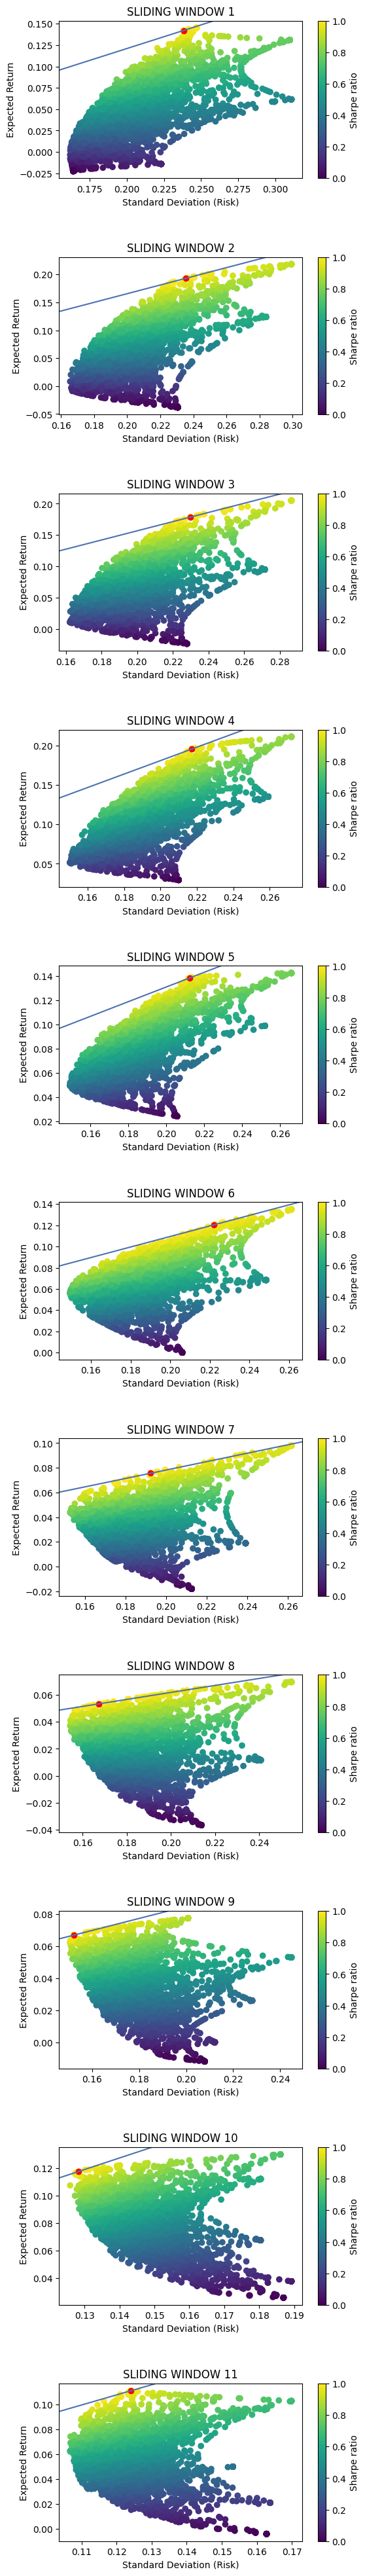

In [249]:
import numpy as np
import matplotlib.pyplot as plt

risk_free_rate = 0.01

 #take a list of lists of frontier returns and variances
f_r = []
f_v = []
sharper = []
w = [] #append weights for each portfolio
frontiers_portfolios = []
highest_sharper_portfolios = []

for j in range(11):
    returns = sliding_windows_data[str(j+1) +'_yearly_mean']
    covariances = sliding_windows_data[str(j+1) +'_yearly_cov']

    frontier_mean_returns = []
    frontier_stds = []

    for i in range(3000):
        weights = np.random.normal(0, 1, size=7) #use normal distribution
        weights = [x if x >= 0 else 0 for x in weights]  
        weights /= np.sum(weights)
        if np.isnan(weights).any():
            continue
        portfolio_return = np.sum(returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))
        frontier_mean_returns.append(portfolio_return)
        frontier_stds.append(portfolio_std)
        w.append(weights)
    frontiers_portfolios.append(w)
    f_r.append(frontier_mean_returns)
    f_v.append(frontier_stds)

    # highest sharper portfolio
    sharper.append(np.array(frontier_mean_returns) / np.array(frontier_stds))
    index = sharper[-1].argmax(axis=0)
    highest_sharper_portfolios.append({
        "return": frontier_mean_returns[index],
        "std": frontier_stds[index],
        "weights": frontiers_portfolios[j][index]})

    

    
# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    im = axs[i].scatter(f_v[i], f_r[i], c=sharper[i])
    im = axs[i].scatter(highest_sharper_portfolios[i]["std"], highest_sharper_portfolios[i]["return"], c="red")
    # plotting capital market line (tobin separation)
    # equivalent to 
    #axs[i].axline((0, risk_free_rate), (highest_sharper_portfolios[i]["std"], highest_sharper_portfolios[i]["return"]))
    # but prettier
    axs[i].axline(
        (min(f_v[i]), (min(f_v[i])/highest_sharper_portfolios[i]["std"])*(highest_sharper_portfolios[i]["return"]-risk_free_rate)+risk_free_rate),
        (highest_sharper_portfolios[i]["std"], highest_sharper_portfolios[i]["return"]))
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    plt.colorbar(im, ax=axs[i], label = 'Sharpe ratio')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()



In [276]:
# Asset Allocation
# I'm calculating optimal asset allocation and turnover for each time window. Maybe we're supposed to do it for each year idk

# required rate of return
rrr = 0.05

# optimal asset allocation:
# mix of max sharpe ratio portfolio and risk free rate that reaches RRR

for i, portfolio in enumerate(highest_sharper_portfolios):

    risk_free_rate_portion = (rrr - portfolio["return"]) / (risk_free_rate - portfolio["return"])
    highest_sharper_portfolios[i]["risk_free_rate_portion"] = risk_free_rate_portion
    highest_sharper_portfolios[i]["weights_incl_rf"] = np.append(portfolio["weights"]*(1-risk_free_rate_portion), risk_free_rate_portion)

    print(f"""{round(risk_free_rate_portion*100)}% of the portfolio in window {str(i+1)} should be risk free at {risk_free_rate*100}%, the remaining {round((1-risk_free_rate_portion)*100)}% have a return of {round(portfolio["return"]*100)}%""")


70% of the portfolio in window 1 should be risk free at 1.0%, the ramaining 30% have a return of 14%
78% of the portfolio in window 2 should be risk free at 1.0%, the ramaining 22% have a return of 19%
76% of the portfolio in window 3 should be risk free at 1.0%, the ramaining 24% have a return of 18%
78% of the portfolio in window 4 should be risk free at 1.0%, the ramaining 22% have a return of 20%
69% of the portfolio in window 5 should be risk free at 1.0%, the ramaining 31% have a return of 14%
64% of the portfolio in window 6 should be risk free at 1.0%, the ramaining 36% have a return of 12%
39% of the portfolio in window 7 should be risk free at 1.0%, the ramaining 61% have a return of 8%
8% of the portfolio in window 8 should be risk free at 1.0%, the ramaining 92% have a return of 5%
30% of the portfolio in window 9 should be risk free at 1.0%, the ramaining 70% have a return of 7%
63% of the portfolio in window 10 should be risk free at 1.0%, the ramaining 37% have a return 

In [279]:

# turnover
# For turnover I'm considering all assets, not just risk free. Not sure if it's correct.
for i, (portfolio, previous_portfolio) in enumerate(zip(highest_sharper_portfolios[1:], highest_sharper_portfolios)):
    
    unchanged_assets = [min(weight_pair) for weight_pair in zip(portfolio["weights_incl_rf"], previous_portfolio["weights_incl_rf"])]
    turnover_rate = 1-sum(unchanged_assets)
    print(f"turnover rate from rolling window {i+1} to rolling window {i+2} is {round(turnover_rate*100)}%")


turnover rate from rolling window 1 to rolling window 2 is 24%
turnover rate from rolling window 2 to rolling window 3 is 14%
turnover rate from rolling window 3 to rolling window 4 is 20%
turnover rate from rolling window 4 to rolling window 5 is 31%
turnover rate from rolling window 5 to rolling window 6 is 30%
turnover rate from rolling window 6 to rolling window 7 is 48%
turnover rate from rolling window 7 to rolling window 8 is 72%
turnover rate from rolling window 8 to rolling window 9 is 92%
turnover rate from rolling window 9 to rolling window 10 is 64%
turnover rate from rolling window 10 to rolling window 11 is 19%


In [ ]:
highest_sharper_portfolios

In [ ]:
#The results might change between runs because the points are computed at random

In [ ]:
for i in range(len(f_r)):
    print("Highest return portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(f_r[i])])
    print("__________________________________________")

In [ ]:
# Less risky portfolio
for i in range(len(f_r)):
    print("Lowest risk portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmin(f_v[i])])
    print("__________________________________________")

In [ ]:
#Highest sharpe ratio

for i in range(11):
    SharpeR = np.array(f_r[i]) / np.array(f_v[i])
    print("Highest Sharpe-ratio portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(SharpeR)])
    print("__________________________________________")

# Let's try to replicate the previous efficient frontiers with a library

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
from pypfopt import EfficientFrontier
from pypfopt import plotting

# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()

### The results are the same, we can use the library to use compute the efficient frontier with risk free rate 1

## Efficient frontier risk free rate

In [ ]:
Rf = 0.01


fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    #need to create another instance
    ef2 = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    Best_portfolio = ef2.max_sharpe(risk_free_rate=0) #best portfolio weights
    stats = ef2.portfolio_performance(verbose=False, risk_free_rate=0)
    Rp = stats[0]
    sigma = stats[1]
    
    xs = np.linspace(0, 2)
    sigma_c = xs * sigma # slide 22 ch05
    Rc = Rf + (Rp - Rf)/sigma * sigma_c
    
    
    opt = axs[i].scatter(sigma, Rp, marker = '*', c = 'red', s=100, label = 'optimal portfolio')#best performance portfolio
    line1, = axs[i].plot(sigma_c, Rc, "-", color="k", linewidth=0.8, label = 'lending and borrowing')
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    axs[i].legend()
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()
